In [1]:
import yaml
import mysql.connector
import os
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import squarify
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import folium

import scipy.stats as stats
from scipy.stats import ks_2samp
from scipy.stats import kstest, norm
from scipy.stats import levene
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

#from sklearn.preprocessing import LabelEncoder, StandardScaler
#from sklearn.cluster import KMeans



import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [2]:
# Load the YAML file
with open("D:\Telangana_Growth_Analysis\db_config.yaml", 'r') as file:
    db_config = yaml.safe_load(file)

# Connect to the database
connection = mysql.connector.connect(**db_config)
cursor = connection.cursor()

![Image](https://drive.google.com/uc?export=view&id=1FDWY3xNgo3ounB-QJaQazWJloBqTKd0B)


In [3]:
# SQL query to join 'fact_stamps' and 'dim_districts' on 'dist_code'

query = """
    select * from vehicles
    inner join districts on vehicles.dist_code = districts.dist_code
    """
# Use pandas to run the query and store the result in a DataFrame
vehicles = pd.read_sql(query, connection)

# Sort the DataFrame by the 'id' column in ascending order
vehicles.sort_values(by='id', ascending=True, inplace=True)
vehicles.reset_index(drop=True, inplace=True)


# Load the 'dim_date' table into a DataFrame
dim_date = pd.read_sql("SELECT * FROM dim_date", connection)

# Merge the 'vehicles' DataFrame with the 'dim_date' DataFrame on the 'month' column
vehicles = pd.merge(vehicles, dim_date, on='month', how='inner')
# Display the first few rows of the merged DataFrame

# Set Pandas display options to show all columns
pd.set_option('display.max_columns', None)
vehicles.head()

,id,dist_code,month,fuel_type_petrol,fuel_type_diesel,fuel_type_electric,fuel_type_others,vehicleClass_MotorCycle,vehicleClass_MotorCar,vehicleClass_AutoRickshaw,vehicleClass_Agriculture,vehicleClass_others,seatCapacity_1_to_3,seatCapacity_4_to_6,seatCapacity_above_6,brand_new_vehicles,pre_owned_vehicles,category_non_transport,category_transport,dist_code,district,mmm,quarter,fiscal_year
0,1,15_1,2019-04-01,17910,3011,76,22,15308,4429,0,4,1278,16110,4182,717,19542,1477,19856,1163,15_1,Rangareddy\r,Apr,Q1,2019
1,2,18_2,2019-04-01,3066,306,6,0,2995,142,49,64,128,3156,189,33,3322,56,3203,175,18_2,Kamareddy\r,Apr,Q1,2019
2,3,20_3,2019-04-01,1577,215,0,0,1546,79,29,21,117,1683,104,5,1751,41,1648,144,20_3,Rajanna Sircilla\r,Apr,Q1,2019
3,4,21_3,2019-04-01,1961,281,2,0,1939,72,72,48,113,2082,146,16,2209,35,2075,169,21_3,Jangoan\r,Apr,Q1,2019
4,5,21_7,2019-04-01,1552,309,0,0,1512,76,69,109,95,1696,145,20,1820,41,1701,160,21_7,Jayashankar Bhupalpally\r,Apr,Q1,2019


In [4]:
#The \r is a carriage return character. 
# it can remove it from the district column using the str.replace method provided by pandas.

vehicles['district'] = vehicles['district'].str.replace('\r', '')

# drop dis_code
vehicles.drop(columns=['dist_code','dist_code'], inplace=True)

vehicles.head()

,id,month,fuel_type_petrol,fuel_type_diesel,fuel_type_electric,fuel_type_others,vehicleClass_MotorCycle,vehicleClass_MotorCar,vehicleClass_AutoRickshaw,vehicleClass_Agriculture,vehicleClass_others,seatCapacity_1_to_3,seatCapacity_4_to_6,seatCapacity_above_6,brand_new_vehicles,pre_owned_vehicles,category_non_transport,category_transport,district,mmm,quarter,fiscal_year
0,1,2019-04-01,17910,3011,76,22,15308,4429,0,4,1278,16110,4182,717,19542,1477,19856,1163,Rangareddy,Apr,Q1,2019
1,2,2019-04-01,3066,306,6,0,2995,142,49,64,128,3156,189,33,3322,56,3203,175,Kamareddy,Apr,Q1,2019
2,3,2019-04-01,1577,215,0,0,1546,79,29,21,117,1683,104,5,1751,41,1648,144,Rajanna Sircilla,Apr,Q1,2019
3,4,2019-04-01,1961,281,2,0,1939,72,72,48,113,2082,146,16,2209,35,2075,169,Jangoan,Apr,Q1,2019
4,5,2019-04-01,1552,309,0,0,1512,76,69,109,95,1696,145,20,1820,41,1701,160,Jayashankar Bhupalpally,Apr,Q1,2019


In [5]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440 entries, 0 to 1439
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         1440 non-null   int64 
 1   month                      1440 non-null   object
 2   fuel_type_petrol           1440 non-null   int64 
 3   fuel_type_diesel           1440 non-null   int64 
 4   fuel_type_electric         1440 non-null   int64 
 5   fuel_type_others           1440 non-null   int64 
 6   vehicleClass_MotorCycle    1440 non-null   int64 
 7   vehicleClass_MotorCar      1440 non-null   int64 
 8   vehicleClass_AutoRickshaw  1440 non-null   int64 
 9   vehicleClass_Agriculture   1440 non-null   int64 
 10  vehicleClass_others        1440 non-null   int64 
 11  seatCapacity_1_to_3        1440 non-null   int64 
 12  seatCapacity_4_to_6        1440 non-null   int64 
 13  seatCapacity_above_6       1440 non-null   int64 
 14  brand_ne

In [6]:
# change date to datetime type

vehicles['month'] = pd.to_datetime(vehicles['month'])

In [7]:
vehicles.describe()

,id,fuel_type_petrol,fuel_type_diesel,fuel_type_electric,fuel_type_others,vehicleClass_MotorCycle,vehicleClass_MotorCar,vehicleClass_AutoRickshaw,vehicleClass_Agriculture,vehicleClass_others,seatCapacity_1_to_3,seatCapacity_4_to_6,seatCapacity_above_6,brand_new_vehicles,pre_owned_vehicles,category_non_transport,category_transport,fiscal_year
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,720.500000,3835.600694,659.294444,71.985417,62.131250,3340.268750,719.743056,93.850694,135.912500,339.327778,3750.516667,768.715278,108.190278,4317.778472,311.343056,4213.104861,416.016667,2020.500000
std,415.836506,5245.789804,684.823903,247.599599,204.991263,4349.406167,1455.487272,197.178758,118.486063,449.467763,4609.407242,1413.933293,209.771880,5531.411539,648.260389,5693.800420,525.924176,1.118422
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,6.000000,0.000000,6.000000,0.000000,2019.000000
25%,360.750000,1346.250000,261.750000,2.000000,2.000000,1229.750000,123.000000,16.000000,49.000000,122.000000,1486.250000,154.000000,20.000000,1629.750000,57.000000,1497.000000,149.000000,2019.750000
50%,720.500000,2067.500000,445.500000,8.000000,6.000000,1887.000000,228.500000,36.000000,105.000000,199.000000,2244.500000,273.000000,38.000000,2457.000000,101.000000,2295.000000,250.000000,2020.500000
75%,1080.250000,3412.000000,744.000000,35.000000,34.000000,3149.250000,432.500000,90.000000,189.000000,332.250000,3635.500000,543.500000,75.250000,4095.250000,167.000000,3783.250000,449.250000,2021.250000
max,1440.000000,39689.000000,5270.000000,2782.000000,2326.000000,35420.000000,8036.000000,2287.000000,786.000000,4299.000000,36694.000000,7918.000000,1337.000000,42073.000000,4450.000000,42074.000000,4239.000000,2022.000000


### General Overview

- The dataset consists of 1440 records.
- The data spans from April 2019 to March 2023.

### Fuel Type

#### Petrol
- The average number of petrol vehicles is around 3835.6, with a wide range from 0 to 39689. 
- The standard deviation is quite high (5245.79), indicating a significant variation in the number of petrol vehicles over the period.

#### Diesel
- On average, there are about 659.3 diesel vehicles. 
- The range is from 0 to 5270, and the standard deviation is 684.82, suggesting some variability but not as much as petrol vehicles.

#### Electric
- Electric vehicles have an average count of 72, with a maximum of 2782. 
- This indicates that while electric vehicles are present, they are not as prevalent as petrol or diesel vehicles.

#### Others
- The other types of fuel vehicles have an average of 62.13, with a maximum of 2326.

### Vehicle Class

#### MotorCycle
- The most common vehicle class with an average of 3340.27, ranging from 0 to 35420.

#### MotorCar
- Averages at 719.74 with a maximum of 8036.

#### AutoRickshaw
- Average count is 93.85, with some months having none and others having as many as 2287.

#### Agriculture
- Averages at 135.91, with a maximum of 786.

#### Others
- Other vehicle classes average at 339.33, with a maximum of 4299.

### Seat Capacity

#### 1 to 3
- The most common seating capacity, averaging at 3750.52.

#### 4 to 6
- Averages at 768.71.

#### Above 6
- Less common with an average of 108.19.

### Vehicle Condition

#### Brand New Vehicles
- On average, there are 4317.78 brand new vehicles, with a maximum of 42073.

#### Pre-Owned Vehicles
- Averages at 311.34, with a maximum of 4450.

### Category

#### Non-Transport
- Averages at 4213.10, with a maximum of 42074.

#### Transport
- Averages at 416.02, with a maximum of 4239.

### Fiscal Year

- The data spans from the fiscal year 2019 to 2022.

## Key Takeaways

- Petrol vehicles are the most common, but there's a significant variation in their numbers.
- Motorcycles are the most prevalent vehicle class.
- Vehicles with a seating capacity of 1 to 3 are the most common.
- Brand new vehicles are more common than pre-owned ones.
- Non-transport vehicles dominate the dataset compared to transport vehicles.


In [27]:
# Load the GeoJSON data
map_file = (r"D:\Telangana_Growth_Analysis\Telangana_Shape_Files\telangana_district_map.json")
geo_data = gpd.read_file(map_file)

In [8]:
vehicles.head()

,id,month,fuel_type_petrol,fuel_type_diesel,fuel_type_electric,fuel_type_others,vehicleClass_MotorCycle,vehicleClass_MotorCar,vehicleClass_AutoRickshaw,vehicleClass_Agriculture,vehicleClass_others,seatCapacity_1_to_3,seatCapacity_4_to_6,seatCapacity_above_6,brand_new_vehicles,pre_owned_vehicles,category_non_transport,category_transport,district,mmm,quarter,fiscal_year
0,1,2019-04-01,17910,3011,76,22,15308,4429,0,4,1278,16110,4182,717,19542,1477,19856,1163,Rangareddy,Apr,Q1,2019
1,2,2019-04-01,3066,306,6,0,2995,142,49,64,128,3156,189,33,3322,56,3203,175,Kamareddy,Apr,Q1,2019
2,3,2019-04-01,1577,215,0,0,1546,79,29,21,117,1683,104,5,1751,41,1648,144,Rajanna Sircilla,Apr,Q1,2019
3,4,2019-04-01,1961,281,2,0,1939,72,72,48,113,2082,146,16,2209,35,2075,169,Jangoan,Apr,Q1,2019
4,5,2019-04-01,1552,309,0,0,1512,76,69,109,95,1696,145,20,1820,41,1701,160,Jayashankar Bhupalpally,Apr,Q1,2019


In [9]:

#%matplotlib inline
# Create the profile report
#profile = ProfileReport(vehicles, title="Profiling Report")

# Specify the path to save the report
#output_file_path = "D:\\Telangana_Growth_Analysis\\y_data\\profiling_report.html"

# Save the report to the specified path
#profile.to_file(output_file_path)

In [10]:
#from autoviz.AutoViz_Class import AutoViz_Class #Instantiate the AutoViz class
#path = (r"D:\Telangana_Growth_Analysis\data\vehicles1.csv")
#AV = AutoViz_Class()
#df = AV.AutoViz(path)

## Problem Statement 5 
### Investigate whether there is any correlation between vehicle sales and specific months or seasons in different districts. Are there any months or seasons that consistently show higher or lower sales rate, and if yes, what could be the driving factors? (Consider Fuel-Type category only)

In [11]:
# Understand the distribution of vehicle sales across different districts and months
district_monthly_sales = vehicles.groupby(['district', 'month']).sum().reset_index()
district_monthly_sales.head()

,district,month,id,fuel_type_petrol,fuel_type_diesel,fuel_type_electric,fuel_type_others,vehicleClass_MotorCycle,vehicleClass_MotorCar,vehicleClass_AutoRickshaw,vehicleClass_Agriculture,vehicleClass_others,seatCapacity_1_to_3,seatCapacity_4_to_6,seatCapacity_above_6,brand_new_vehicles,pre_owned_vehicles,category_non_transport,category_transport,fiscal_year
0,Adilabad,2019-04-01,28,1758,326,0,2,1697,116,77,13,183,1823,184,79,2061,25,1832,254,2019
1,Adilabad,2019-05-01,32,1870,190,0,9,1823,96,71,6,73,1883,159,27,2040,29,1926,143,2019
2,Adilabad,2019-06-01,63,1384,243,0,2,1352,105,93,0,79,1399,186,44,1599,30,1469,160,2019
3,Adilabad,2019-07-01,118,1264,197,0,9,1230,84,72,10,74,1299,151,20,1455,15,1328,142,2019
4,Adilabad,2019-08-01,136,1137,209,1,4,1103,89,71,6,82,1181,145,25,1330,21,1203,148,2019


In [26]:
# Directory to save the plot
save_dir = "D:\\Telangana_Growth_Analysis\\notebooks\\plots\\vehicles\\5"

# Ensure the directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# Group by district and sum up the sales for all fuel types
district_total_sales = vehicles.groupby('district').sum()[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others']]

# Sort the data by total sales
district_total_sales['total_sales'] = district_total_sales.sum(axis=1)
sorted_district_sales = district_total_sales.sort_values(by='total_sales')

# Create the stacked horizontal bar plot
fig = go.Figure(data=[
    go.Bar(name='Petrol', y=sorted_district_sales.index, x=sorted_district_sales['fuel_type_petrol'], orientation='h'),
    go.Bar(name='Diesel', y=sorted_district_sales.index, x=sorted_district_sales['fuel_type_diesel'], orientation='h'),
    go.Bar(name='Electric', y=sorted_district_sales.index, x=sorted_district_sales['fuel_type_electric'], orientation='h'),
    go.Bar(name='Others', y=sorted_district_sales.index, x=sorted_district_sales['fuel_type_others'], orientation='h')
])

# Update layout to stack the bars
fig.update_layout(barmode='stack', 
                  title="Total Vehicle Sales by District (Stacked by Fuel Type)",
                  xaxis_title='Number of Vehicles Sold',
                  yaxis_title='District',
                  template="plotly_dark",
                  height=1000,
                  legend=dict(y=-0.0, x=0.4, xanchor='center', orientation='h'))

# Display the figure
fig.show()

# Save the figure as an HTML file
fig.write_html(os.path.join(save_dir, "total_vehicle_sales_by_district.html"))

In [32]:
# Merge the GeoDataFrame with the district sales data
merged_data = geo_data.merge(sorted_district_sales, left_on='Dist_Name', right_index=True)

# Create the interactive map
fig = px.choropleth_mapbox(merged_data, 
                           geojson=merged_data.geometry, 
                           locations=merged_data.index, 
                           color="total_sales",
                           hover_name="Dist_Name",
                           hover_data=["fuel_type_petrol", "fuel_type_diesel", "fuel_type_electric", "fuel_type_others"],
                           title="Vehicle Sales by District",
                           mapbox_style="carto-positron",
                           center={"lat": merged_data.geometry.centroid.y.mean(), "lon": merged_data.geometry.centroid.x.mean()},
                           zoom=3,
                           opacity=0.5)

# Display the figure
fig.show()

In [48]:
def visualize_district_sales_interactive(geo_data, district_sales):
    # Merge the geo_data and district_sales dataframes based on district names
    merged = geo_data.merge(district_sales, left_on='Dist_Name', right_on='district', how='left')
    
    # Fill missing values with 0
    merged[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others', 'total_sales']] = merged[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others', 'total_sales']].fillna(0)
    
    # Create the interactive map
    fig = px.choropleth(merged, 
                        geojson=merged.geometry, 
                        locations=merged.index, 
                        color='total_sales',
                        color_continuous_scale="Viridis",
                        labels={'total_sales':'Total Vehicle Sales'},
                        hover_name='Dist_Name',
                        hover_data=['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others'],
                        title="Vehicle Sales by District in Telangana")
    
    fig.update_geos(fitbounds="locations", visible=False)
    
    # Adjust the layout to make the plot square-shaped and larger
    fig.update_layout(width=800, height=600)
    
    fig.show()

# Use the function
geo_data = gpd.read_file(map_file)
visualize_district_sales_interactive(geo_data, sorted_district_sales)


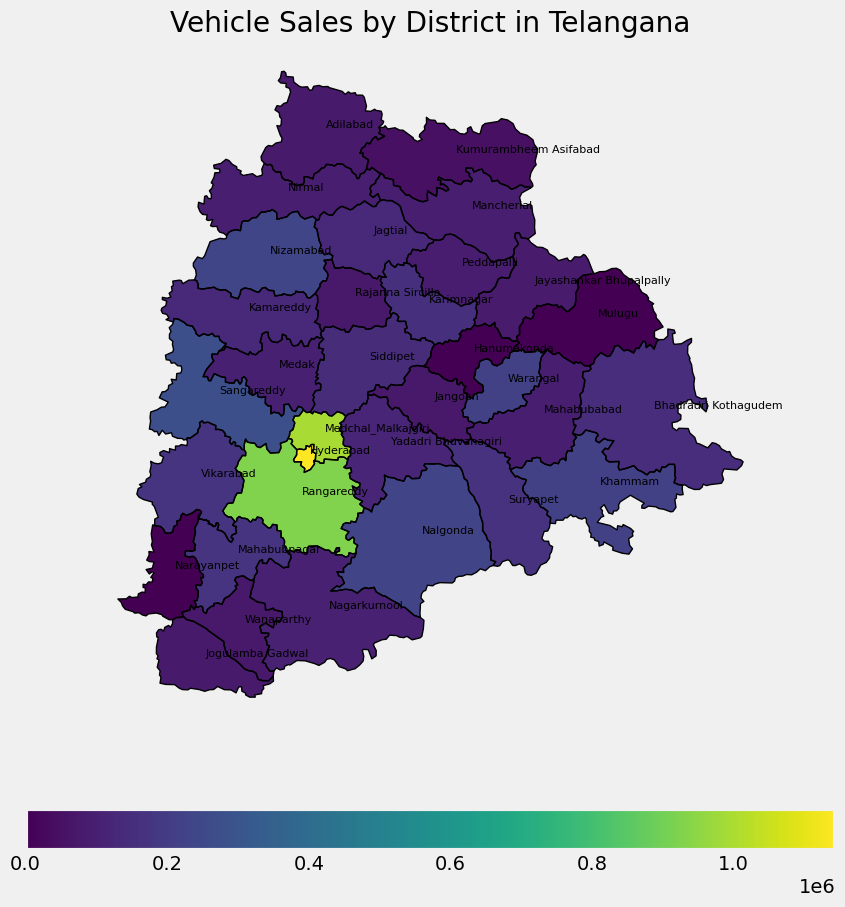

In [49]:
def visualize_district_sales_matplotlib(geo_data, district_sales):
    # Merge the geo_data and district_sales dataframes based on district names
    merged = geo_data.merge(district_sales, left_on='Dist_Name', right_on='district', how='left')
    
    # Fill missing values with 0
    merged[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others', 'total_sales']] = merged[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others', 'total_sales']].fillna(0)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    merged.boundary.plot(ax=ax, linewidth=1, color='black')
    merged.plot(column='total_sales', ax=ax, legend=True, cmap='viridis', 
                legend_kwds={'orientation': "horizontal", 'fraction': 0.05, 'pad': 0.1})
    
    # Annotate district names
    for x, y, label in zip(merged.geometry.centroid.x, merged.geometry.centroid.y, merged['Dist_Name']):
        ax.annotate(label, xy=(x, y), xytext=(3,3), textcoords="offset points", fontsize=8)
    
    ax.set_title("Vehicle Sales by District in Telangana")
    ax.axis('off')
    plt.show()

# Use the function
geo_data = gpd.read_file(map_file)
visualize_district_sales_matplotlib(geo_data, sorted_district_sales)

In [12]:
# Directory to save plots
save_dir = "D:\\Telangana_Growth_Analysis\\notebooks\\plots\\vehicles\\indvidual_dist_analysis"

# Ensure the directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# List of unique districts
districts = district_monthly_sales['district'].unique()

for district in districts:
    # Filter data for the current district
    district_data = district_monthly_sales[district_monthly_sales['district'] == district]
    
    # Create the line plot
    plt.figure(figsize=(12, 6))
    
    # Plot each fuel type
    plt.plot(district_data['month'], district_data['fuel_type_petrol'], marker='o', label='Fuel Type Petrol', color='green')
    plt.plot(district_data['month'], district_data['fuel_type_diesel'], marker='o', label='Fuel Type Diesel', color='red')
    plt.plot(district_data['month'], district_data['fuel_type_electric'], marker='o', label='Fuel Type Electric', color='blue')
    plt.plot(district_data['month'], district_data['fuel_type_others'], marker='o', label='Fuel Type Others', color='yellow')
    
    # Add title and labels
    plt.title(f"Monthly Vehicle Sales Trends for {district}")
    plt.xlabel('Month')
    plt.ylabel('Number of Vehicles Sold')
    plt.legend(loc='best')
    plt.grid(True)
    
    # Save the figure
    plt.savefig(os.path.join(save_dir, f"{district}_vehicle_sales_trends.png"))
    plt.close()

In [ ]:
# Directory to save plots
save_dir = "D:\\Telangana_Growth_Analysis\\notebooks\\plots\\vehicles\\indvidual_dist_analysis\\html_plots"

# Ensure the directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# List of unique districts
districts = district_monthly_sales['district'].unique()

for district in districts:
    # Filter data for the current district
    district_data = district_monthly_sales[district_monthly_sales['district'] == district]
    
    # Create the line plot
    fig = go.Figure()

    # Add traces for each fuel type
    fig.add_trace(go.Scatter(x=district_data['month'], 
                             y=district_data['fuel_type_petrol'], 
                             mode='lines+markers',
                             name='Fuel Type Petrol',
                             line=dict(color='green')))
    
    fig.add_trace(go.Scatter(x=district_data['month'], 
                             y=district_data['fuel_type_diesel'], 
                             mode='lines+markers',
                             name='Fuel Type Diesel',
                             line=dict(color='red')))
    
    fig.add_trace(go.Scatter(x=district_data['month'], 
                             y=district_data['fuel_type_electric'], 
                             mode='lines+markers',
                             name='Fuel Type Electric',
                             line=dict(color='blue')))
    
    fig.add_trace(go.Scatter(x=district_data['month'], 
                             y=district_data['fuel_type_others'], 
                             mode='lines+markers',
                             name='Fuel Type Others',
                             line=dict(color='yellow')))

    # Update layout
    fig.update_layout(title=f"Monthly Vehicle Sales Trends for {district}",
                      xaxis_title='Month',
                      yaxis_title='Number of Vehicles Sold',
                      template="plotly_dark",
                      legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'))

    # Display the figure
    fig.show()

    # Save the figure as HTML
    fig.write_html(os.path.join(save_dir, f"{district}_vehicle_sales_trends.html"))

In [16]:
# Directory to save plots
save_dir = "D:\\Telangana_Growth_Analysis\\notebooks\\plots\\vehicles\\5"

# Ensure the directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Monthly Analysis
monthly_sales = vehicles.groupby('month').sum()[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others']]

# Create the line plot for Monthly Analysis
fig_monthly = go.Figure()

# Add traces for each fuel type
for fuel_type, color in zip(['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others'], ['green', 'red', 'blue', 'yellow']):
    fig_monthly.add_trace(go.Scatter(x=monthly_sales.index, 
                                     y=monthly_sales[fuel_type], 
                                     mode='lines+markers',
                                     name=fuel_type.split('_')[-1].capitalize(),
                                     line=dict(color=color)))

# Update layout
fig_monthly.update_layout(title='Monthly Sales of Vehicles by Fuel Type',
                          xaxis_title='Month',
                          yaxis_title='Number of Vehicles Sold',
                          template="plotly_dark",
                          legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'))

# Display the figure
fig_monthly.show()

# Save the Monthly Analysis figure as HTML
fig_monthly.write_html(os.path.join(save_dir, "monthly_vehicle_sales_trends.html"))

# Seasonal Analysis
seasonal_sales = vehicles.groupby('quarter').sum()[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others']]

# Create the line plot for Seasonal Analysis
fig_seasonal = go.Figure()

# Add traces for each fuel type
for fuel_type, color in zip(['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others'], ['green', 'red', 'blue', 'yellow']):
    fig_seasonal.add_trace(go.Scatter(x=seasonal_sales.index, 
                                      y=seasonal_sales[fuel_type], 
                                      mode='lines+markers',
                                      name=fuel_type.split('_')[-1].capitalize(),
                                      line=dict(color=color)))

# Update layout
fig_seasonal.update_layout(title='Seasonal Sales of Vehicles by Fuel Type',
                           xaxis_title='Quarter',
                           yaxis_title='Number of Vehicles Sold',
                           template="plotly_dark",
                           legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'))

# Display the figure
fig_seasonal.show()

# Save the Seasonal Analysis figure as HTML
fig_seasonal.write_html(os.path.join(save_dir, "seasonal_vehicle_sales_trends.html"))

Correlation Analysis:

In [50]:
vehicles.columns

Index(['id', 'month', 'fuel_type_petrol', 'fuel_type_diesel',
       'fuel_type_electric', 'fuel_type_others', 'vehicleClass_MotorCycle',
       'vehicleClass_MotorCar', 'vehicleClass_AutoRickshaw',
       'vehicleClass_Agriculture', 'vehicleClass_others',
       'seatCapacity_1_to_3', 'seatCapacity_4_to_6', 'seatCapacity_above_6',
       'brand_new_vehicles', 'pre_owned_vehicles', 'category_non_transport',
       'category_transport', 'district', 'mmm', 'quarter', 'fiscal_year'],
      dtype='object')

In [51]:
vehicles.head()

,id,month,fuel_type_petrol,fuel_type_diesel,fuel_type_electric,fuel_type_others,vehicleClass_MotorCycle,vehicleClass_MotorCar,vehicleClass_AutoRickshaw,vehicleClass_Agriculture,vehicleClass_others,seatCapacity_1_to_3,seatCapacity_4_to_6,seatCapacity_above_6,brand_new_vehicles,pre_owned_vehicles,category_non_transport,category_transport,district,mmm,quarter,fiscal_year
0,1,2019-04-01,17910,3011,76,22,15308,4429,0,4,1278,16110,4182,717,19542,1477,19856,1163,Rangareddy,Apr,Q1,2019
1,2,2019-04-01,3066,306,6,0,2995,142,49,64,128,3156,189,33,3322,56,3203,175,Kamareddy,Apr,Q1,2019
2,3,2019-04-01,1577,215,0,0,1546,79,29,21,117,1683,104,5,1751,41,1648,144,Rajanna Sircilla,Apr,Q1,2019
3,4,2019-04-01,1961,281,2,0,1939,72,72,48,113,2082,146,16,2209,35,2075,169,Jangoan,Apr,Q1,2019
4,5,2019-04-01,1552,309,0,0,1512,76,69,109,95,1696,145,20,1820,41,1701,160,Jayashankar Bhupalpally,Apr,Q1,2019


In [59]:
# Convert 'month' to datetime format and extract the month number
vehicles['month_num'] = pd.to_datetime(vehicles['month']).dt.month

# Calculate total sales for each month by summing up sales of all fuel types
vehicles['total_sales'] = vehicles[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others']].sum(axis=1)

# Group by month number and sum up the total sales for each month
monthly_sales = vehicles.groupby('month_num')['total_sales'].sum()


# Convert the index and the series to arrays
months_array = np.array(monthly_sales.index)
sales_array = np.array(monthly_sales)

# Calculate the correlation using numpy's corrcoef method
correlation_matrix = np.corrcoef(months_array, sales_array)
correlation = correlation_matrix[0, 1]

print(f"Correlation between month and total sales: {correlation:.2f}")


Correlation between month and total sales: 0.24


The result, Correlation between month and total sales: 0.24, indicates a weak positive correlation between the month number and total sales. This means that, on average, as months progress from January to December, there's a slight increase in sales. However, the correlation is weak, so the relationship isn't very strong.

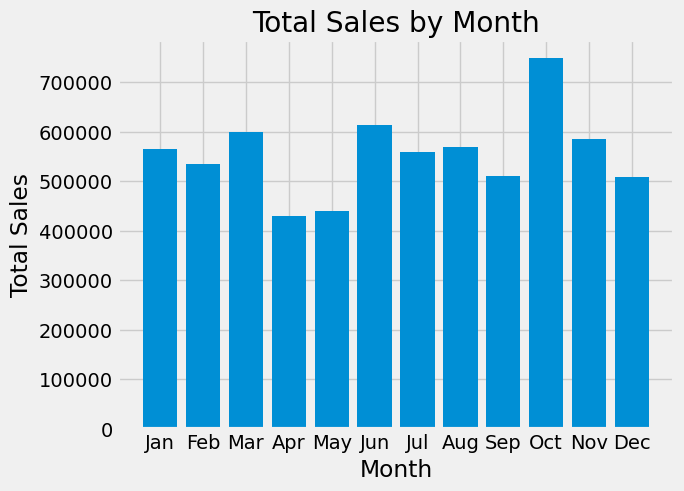

In [62]:
# Sort monthly sales by month number (from Jan to Dec)
sorted_by_month = monthly_sales.sort_index()

# Visualization
plt.bar(sorted_by_month.index, sorted_by_month.values)
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month')
plt.xticks(sorted_by_month.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


In [66]:
# Ensure the 'month' column is in datetime format
vehicles['month'] = pd.to_datetime(vehicles['month'])

# Group by month and calculate the sum of sales for each fuel type
monthly_sales = vehicles.groupby(vehicles['month'].dt.strftime('%B')).sum()[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others']]
# Sort by month from January to December
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_sales = monthly_sales.reindex(months_order)

# Create a combined line and bar plot
fig = go.Figure()

# Add bar plot for the sum of sales for each month
fig.add_trace(go.Bar(x=monthly_sales.index, 
                     y=monthly_sales.sum(axis=1), 
                     name='Total Sales',
                     marker_color='skyblue'))

# Add line plots for each fuel type
colors = ['green', 'red', 'blue', 'yellow']
for fuel_type, color in zip(['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others'], colors):
    fig.add_trace(go.Scatter(x=monthly_sales.index, 
                             y=monthly_sales[fuel_type], 
                             mode='lines+markers',
                             name=fuel_type.split('_')[-1].capitalize(),
                             line=dict(color=color)))

# Update layout
fig.update_layout(title='Monthly Sales of Vehicles by Fuel Type',
                  xaxis_title='Month',
                  yaxis_title='Number of Vehicles Sold',
                  template="plotly_dark",
                  legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'))

# Display the figure
fig.show()

# Save the figure as HTML
fig.write_html(os.path.join(save_dir, "combined_monthly_vehicle_sales_trends.html"))